In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency
import scipy

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
from Bio import AlignIO
import time as time
import pandas as pd

In [2]:
starttime = time.time()

#Open data from h5py

data_path = '../../../data_RFAM/riboswitch_100k_d5.hdf5'
with h5py.File(data_path, 'r') as dataset:
    X_data = np.array(dataset['X_data'])
    Y_data = np.array(dataset['Y_data'])
    
numdata, seqlen, _, dims = X_data.shape
dims = dims-1

#remove gaps from sequences
ungapped = True
if ungapped:
    X_data = X_data[:, :, :, :dims]
    
# get validation and test set from training set
test_frac = 0.3
valid_frac = 0.1
N = numdata
split_1 = int(N*(1-valid_frac-test_frac))
split_2 = int(N*(1-test_frac))
shuffle = np.random.permutation(N)

#set up dictionaries
train = {'inputs': X_data[shuffle[:split_1]], 
         'targets': Y_data[shuffle[:split_1]]}
valid = {'inputs': X_data[shuffle[split_1:split_2]], 
         'targets': Y_data[shuffle[split_1:split_2]]}
test = {'inputs': X_data[shuffle[split_2:]], 
         'targets': Y_data[shuffle[split_2:]]}
    
print ('Data extraction and dict construction completed in: ' + mf.sectotime(time.time() - starttime))

Data extraction and dict construction completed in: 10.02s


In [3]:
simalign_file = '../../../data_RFAM/riboswitch_100k.sto'

#Get the full secondary structure and sequence consensus from the emission
SS = mf.getSSconsensus(simalign_file)
SQ = mf.getSQconsensus(simalign_file)

#Get the ungapped sequence and the indices of ungapped nucleotides
_, ugSS, ugidx = mf.rm_consensus_gaps(X_data, SS)
_, ugSQ, _ = mf.rm_consensus_gaps(X_data, SQ)


#Get the sequence and indices of the conserved base pairs
bpchars = ['(',')','<','>','{','}']
sig_bpchars = ['<','>']
bpidx, bpSS, nonbpidx = mf.sigbasepair(SS, bpchars)
numbp = len(bpidx)
numug = len(ugidx)

#Get the bpug information
bpugSQ, bpugidx = mf.bpug(ugidx, bpidx, SQ)

bpSS

'(((((<<<<<<>>>>>><<<<<<<<<>>>>>>>>>)))))<<<<>>>>'

In [4]:
SS

'.......:.......:......:.......:......:.....(...(.....(....(...(.......,.........,......,......,......<.......-.....<....<...<....<...<..................._....._......_......_.........................>....>....>...>.....>.......>....<...<...<.......-.......-....<...<....<.....<....<...<..............._......._....._....._........_......_..............>....>...>....-........>...>....>.....-..........>....>....>.....,.......................................................,.....,......,......,.............................................................)...)....)....)...).....-....<...<...<....<..........................._........_........_......_........................................>....>.....>....>.......:....:.............:....:....:.......:....:....:....:....:....:.....:......:.....:.....:......:......'

In [5]:
def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    
    layer2 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                        # concat, embedding, variational_normal, variational_softmax, + more
              'num_units': 44,
              'norm': 'batch',          # if removed, automatically adds bias instead
              'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
              'dropout': 0.5,           # if removed, default is no dropout
             }
    
    layer3 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = '../../../results/riboswitch'
param_path = os.path.join(save_path, 'mlp_t3_44')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 816, 1, 4)
layer2: dense_0
(?, 44)
layer3: dense_0_batch
(?, 44)
layer4: dense_0_active
(?, 44)
layer5: dense_0_dropout
(?, 44)
layer6: dense_1
(?, 1)
layer7: dense_1_bias
(?, 1)
layer8: output
(?, 1)
----------------------------------------------------------------------------


In [6]:
# initialize session
sess = utils.initialize_session()

In [7]:
#Train the model

data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, 
                    batch_size=100, 
                    num_epochs=100,
                    patience=40, 
                    verbose=2, 
                    shuffle=True, 
                    save_all=False)

Epoch 1 out of 100 
[==============================] 100.0% -- elapsed time=3.83s -- loss=0.47656 -- acc=76.343334%  
 
  valid loss:		0.15236
  valid accuracy:	0.98090+/-0.00000
  valid auc-roc:	0.99833+/-0.00000
  valid auc-pr:		0.99844+/-0.00000
  lower cross-validation found
  saving model to:  ../../../results/riboswitch/mlp_t3_44_best.ckpt
Epoch 2 out of 100 
[==============================] 100.0% -- elapsed time=3.80s -- loss=0.20376 -- acc=92.328343%  
 
  valid loss:		0.07097
  valid accuracy:	0.99010+/-0.00000
  valid auc-roc:	0.99946+/-0.00000
  valid auc-pr:		0.99950+/-0.00000
  lower cross-validation found
  saving model to:  ../../../results/riboswitch/mlp_t3_44_best.ckpt
Epoch 3 out of 100 
[==============================] 100.0% -- elapsed time=3.86s -- loss=0.15891 -- acc=94.120842%  
 
  valid loss:		0.05136
  valid accuracy:	0.99150+/-0.00000
  valid auc-roc:	0.99964+/-0.00000
  valid auc-pr:		0.99966+/-0.00000
  lower cross-validation found
  saving model to:  ../.

In [8]:
# initialize session
sess.close()
sess = utils.initialize_session()

In [9]:
# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

loading model from:  ../../../results/riboswitch/mlp_t3_44_best.ckpt
INFO:tensorflow:Restoring parameters from ../../../results/riboswitch/mlp_t3_44_best.ckpt
  test  loss:		0.02712
  test  accuracy:	0.99600+/-0.00000
  test  auc-roc:	0.99990+/-0.00000
  test  auc-pr:		0.99990+/-0.00000


In [10]:
# sort activations
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
plot_index = np.argsort(predictionsoutput[:,0])[::-1]


/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


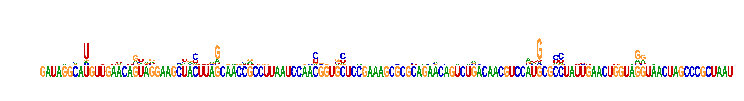

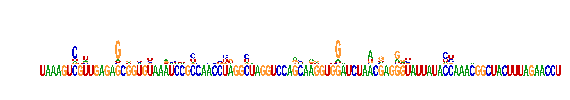

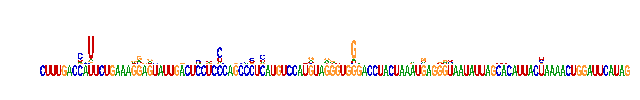

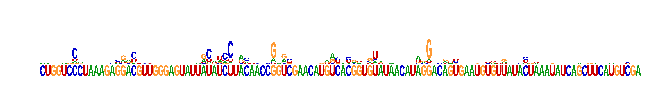

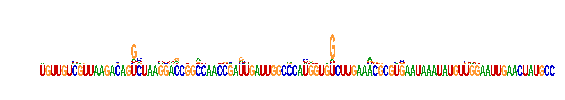

In [11]:
num_plots=np.linspace(0,30000,5).astype(int)
#num_plots = range(5)
for ii in num_plots: 

    X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)
    
    mf.fom_saliency(X, layer='dense_1_bias', alphabet='rna', nntrainer=nntrainer, sess=sess, figsize=(15,1.5))

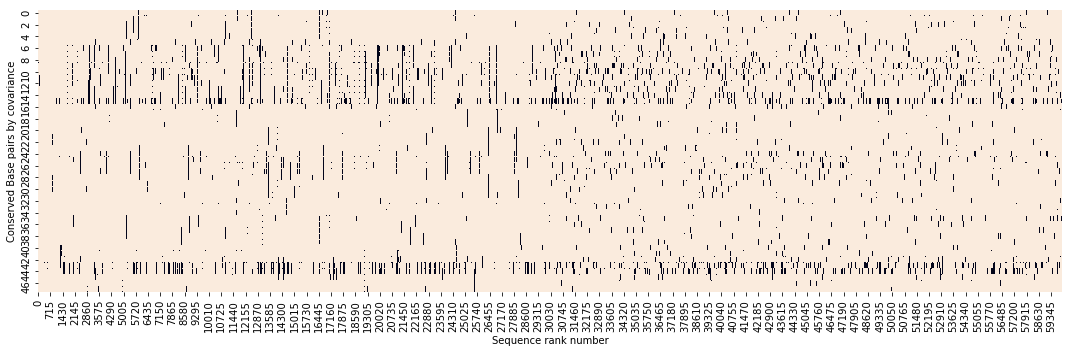

In [12]:
#num_plots=np.linspace(0,10000,10).astype(int)
num_plots = range(int(numdata*test_frac))
#for sp, ii in enumerate(num_plots): 
    
def nucpresence(Xdict, ii):
    X = np.expand_dims(Xdict['inputs'][plot_index[ii]], axis=0)
    nuc_index = np.where(np.sum(X, axis=0)!=0)[0]
    nucpos = np.zeros(shape=(1,seqlen))
    nucpos[:, nuc_index] = 1.
    return nucpos

nuc_sequences = [nucpresence(test,ii) for ii in num_plots]
    
plt.figure(figsize=(15,5))
sb.heatmap(np.squeeze(nuc_sequences)[:, bpidx].T, cbar=False)
plt.ylabel('Conserved Base pairs by covariance')
plt.xlabel('Sequence rank number')


In [13]:
savepath = 'Arrays/riboswitch_mlpt3_44_ug_so1k.npy'

num_summary = 1000
Xdict = test['inputs'][plot_index[:num_summary]]

sum_mut2 = mf.som_average_ungapped(Xdict, ungapped_index=ugidx, savepath=savepath, nntrainer=nntrainer, 
                                sess=sess, progress='on', save=True, layer='dense_1_bias', 
                               normalize=False, normfactor=0)

0
Epoch duration =2.34s
Cumulative duration =2.34s

1
Epoch duration =2.33s
Cumulative duration =4.68s

2
Epoch duration =2.36s
Cumulative duration =7.04s

3
Epoch duration =2.34s
Cumulative duration =9.38s

4
Epoch duration =2.35s
Cumulative duration =11.73s

5
Epoch duration =2.34s
Cumulative duration =14.07s

6
Epoch duration =2.33s
Cumulative duration =16.4s

7
Epoch duration =2.34s
Cumulative duration =18.74s

8
Epoch duration =2.33s
Cumulative duration =21.07s

9
Epoch duration =2.35s
Cumulative duration =23.42s

10
Epoch duration =2.46s
Cumulative duration =25.88s

11
Epoch duration =2.34s
Cumulative duration =28.22s

12
Epoch duration =2.39s
Cumulative duration =30.61s

13
Epoch duration =2.35s
Cumulative duration =32.96s

14
Epoch duration =2.33s
Cumulative duration =35.29s

15
Epoch duration =2.32s
Cumulative duration =37.62s

16
Epoch duration =2.32s
Cumulative duration =39.94s

17
Epoch duration =2.34s
Cumulative duration =42.28s

18
Epoch duration =2.32s
Cumulative duratio

In [14]:
#load values
savepath = 'Arrays/riboswitch_mlpt3_44_ug_so1k.npy'
sum_mut2 = np.load(savepath)

#average the values
num_summary = 1000
mean_mut2 = sum_mut2/num_summary

#Reshape into a holistic tensor organizing the mutations into 4*4 matrices
meanhol_mut2 = mean_mut2.reshape(numug,numug,dims,dims)

In [15]:
#normalize the holistic mutation scores
WT_mean = np.mean(nntrainer.get_activations(sess, test, layer='dense_1_bias')[plot_index[:500]])

norm_meanhol_mut2 = mf.normalize_mut_hol(meanhol_mut2, WT_mean, nntrainer, sess)

<function matplotlib.pyplot.show>

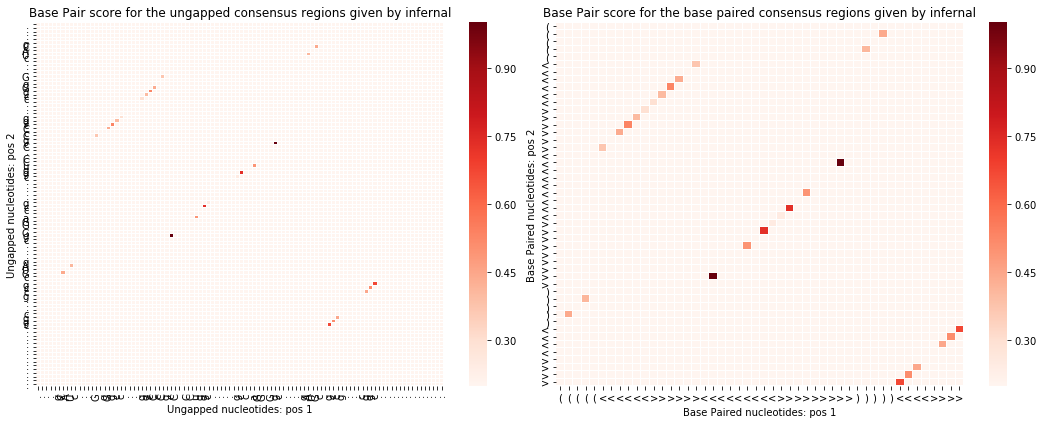

In [16]:
#Let's try something weird
bpfilter = np.ones((4,4))*-1
for i,j in zip(range(4), range(4)):
    bpfilter[i, -(j+1)] = 1.
    
C = np.sum((norm_meanhol_mut2*bpfilter).reshape(numug,numug,dims*dims), axis=2)
C = C - np.mean(C)
C = C/np.max(C)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(C, xticklabels=bpugSQ, yticklabels=bpugSQ, vmin=0.2, cmap='Reds', linewidth=0.01)
plt.title('Base Pair score for the ungapped consensus regions given by infernal')
plt.xlabel('Ungapped nucleotides: pos 1')
plt.ylabel('Ungapped nucleotides: pos 2')
plt.subplot(1,2,2)
sb.heatmap(C[bpugidx][:, bpugidx], xticklabels=bpSS, yticklabels=bpSS, vmin=0.2, vmax=1.0, cmap='Reds', linewidth=0.01)
plt.title('Base Pair score for the base paired consensus regions given by infernal')
plt.xlabel('Base Paired nucleotides: pos 1')
plt.ylabel('Base Paired nucleotides: pos 2')
plt.show